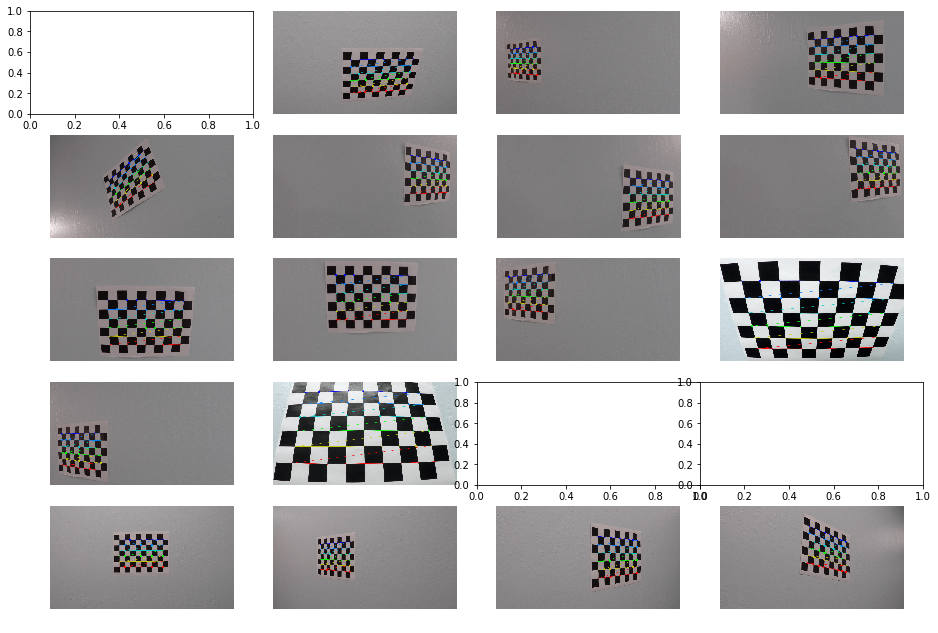

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

True

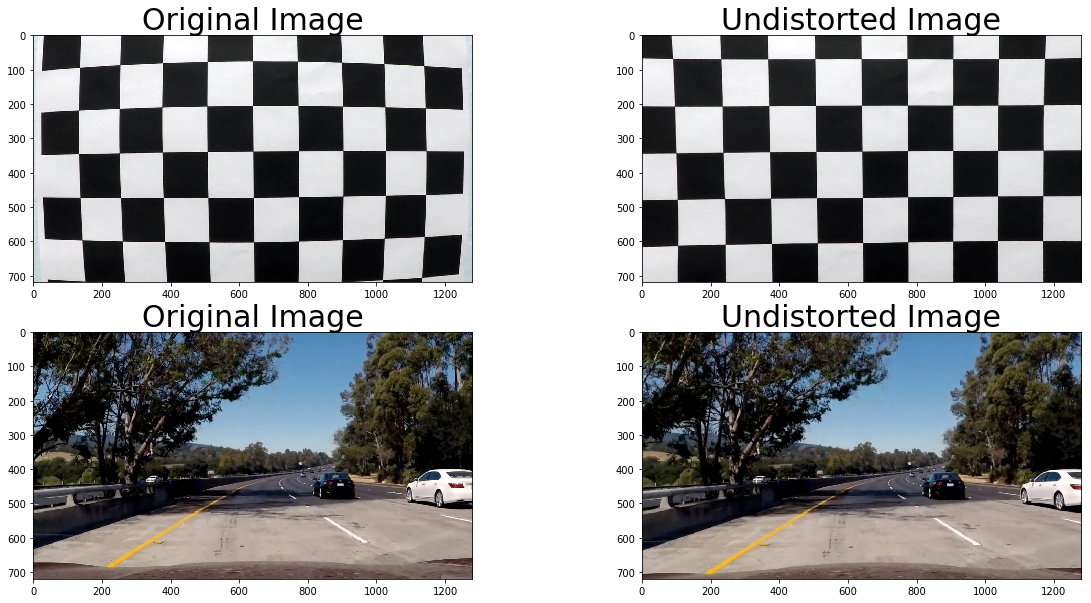

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# Visualize undistortion
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image", fontsize=30)
plt.subplot(2, 2, 2)
plt.imshow(dst)
plt.title("Undistorted Image", fontsize=30)
img = cv2.imread('test_images/test5.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=30)
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(cv2.undistort(img, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image", fontsize=30)
plt.savefig("output_images/undist_img.png")
cv2.imwrite('output_images/test_undist_img.jpg',cv2.undistort(img, mtx, dist, None, mtx))

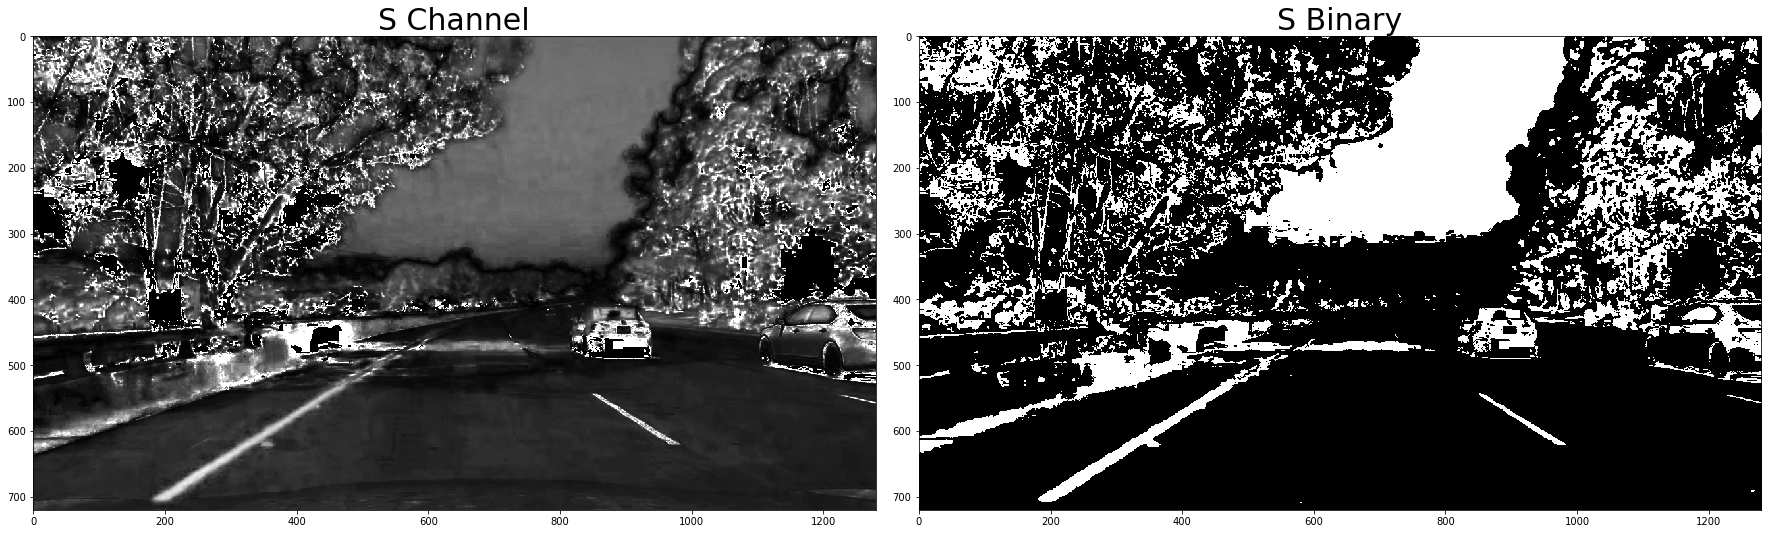

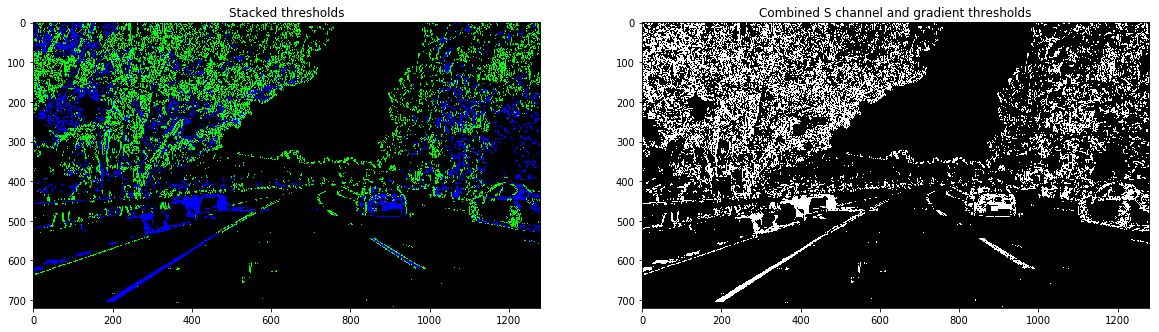

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('output_images/test_undist_img.jpg')

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

thresh = (90, 255)
binary = np.zeros_like(s_channel)
binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(s_channel, cmap='gray')
ax1.set_title('S Channel', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('S Binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

dst [[  325.   720.]
 [  325.     0.]
 [ 1010.     0.]
 [ 1010.   720.]]


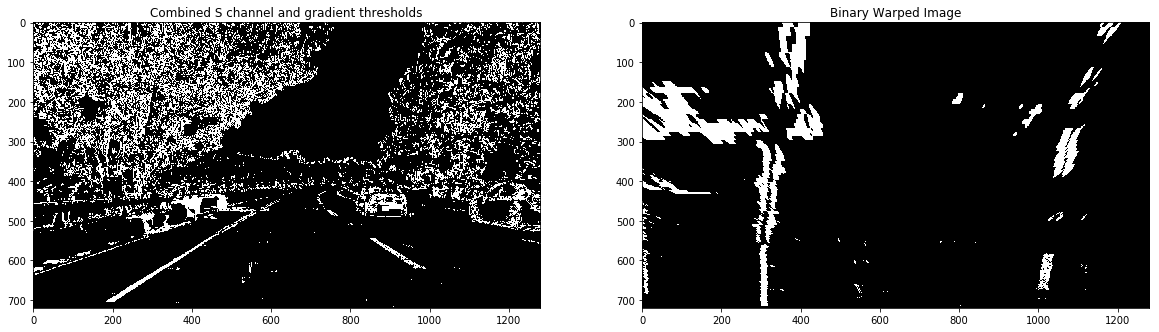

In [4]:
# Helpful Source: https://github.com/ksakmann/CarND-Advanced-Lane-Lines
offset=[135,0]
img_size = (combined_binary.shape[1], combined_binary.shape[0])
width, height = img_size
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
top_l=np.array([corners[0,0],0])
top_r=np.array([corners[3,0],0])
src = np.float32([corners[0],corners[1],corners[2],corners[3]])
dst = np.float32([corners[0]+offset,top_l+offset,top_r-offset ,corners[3]-offset]) 
print('dst {}'.format(dst))
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(combined_binary, cmap='gray')
plt.title('Combined S channel and gradient thresholds')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(combined_binary,M, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')
plt.savefig("output_images/binary_warp_img.png")

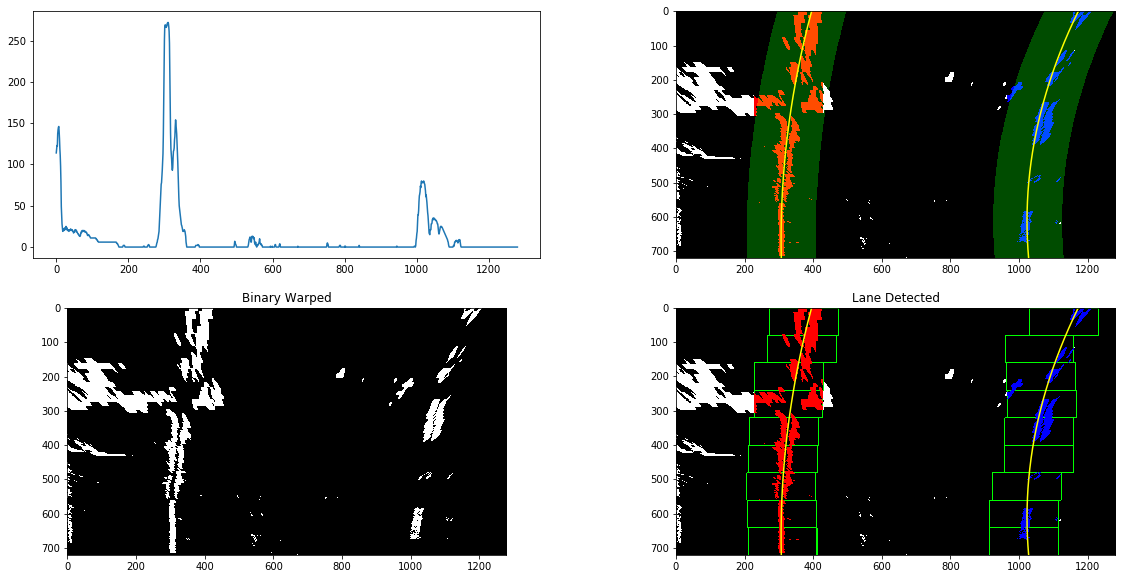

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(histogram)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.subplot(2, 2, 3)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(2, 2, 4)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.subplot(2, 2, 2)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("output_images/histogram_Detect_lane_img.png")

557.455484448 m 581.250480171 m


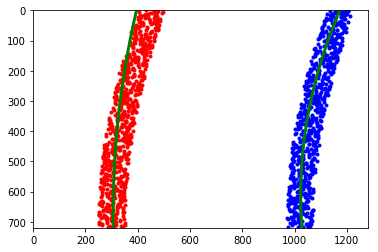

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some fake data to represent lane-line pixels
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=130 for left, and x=1140 for right)
leftx = np.array([300 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([1020 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

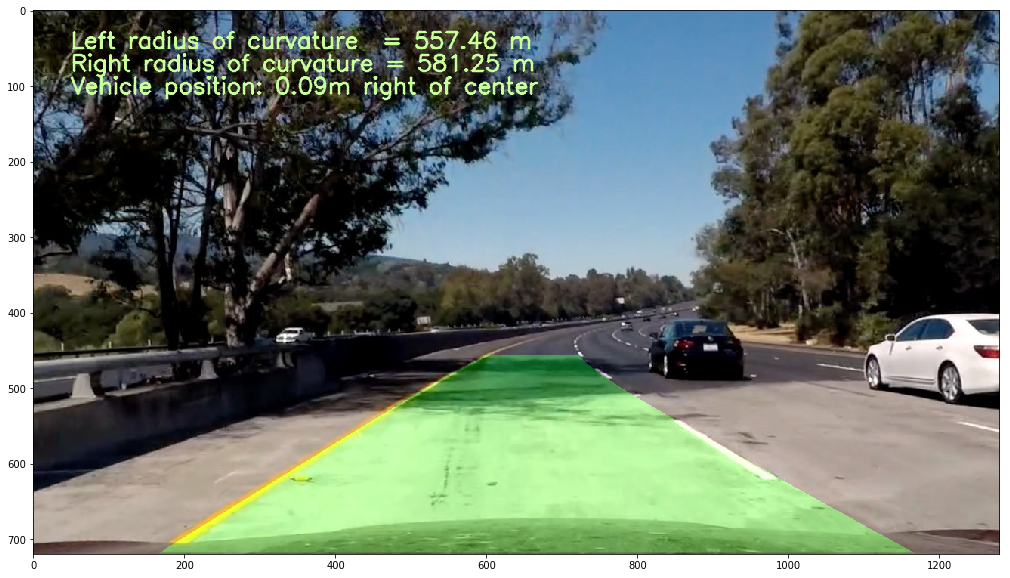

In [7]:
midx = 650

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad),(50,50), font, 1,(200,255,155),2,cv2.LINE_AA)
cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), font, 1,(200,255,155),2,cv2.LINE_AA)
cv2.putText(result,'Vehicle position: %.2fm %s of center' % (np.absolute(position_from_center), text),(50,110), cv2.FONT_HERSHEY_SIMPLEX, 1,(200,255,155),2,cv2.LINE_AA)
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.savefig("output_images/find_lane.png")

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Apply HLS and sobel masks to the image
def region_of_interest(img):
    img = img.copy()
    
    # Apply a mask on HLS color channels
    # Select pixels with higher than 100 saturation and lower than 100 hue
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    mask = np.zeros_like(hls[:, :, 0])
    mask[(hls[:, :, 2] > 100) & (hls[:, :, 0] < 100)] = 1
    
    # Apply sobel magnitude threshold On the bottom half select pixels with >10 sobel magnitude, and on the top half,  
    # selects pixels with >35 sobel magnitude
    top_mag = mag_thresh(img, 3, (10, 255))
    bottom_mag = mag_thresh(img, 3, (35, 255))
    mag_mask = np.zeros_like(bottom_mag)
    mag_mask[:int(mag_mask.shape[0]/2), :] = top_mag[:int(mag_mask.shape[0]/2), :]
    mag_mask[int(mag_mask.shape[0]/2):, :] = bottom_mag[int(mag_mask.shape[0]/2):, :]
    
    # Use the bitwise OR mask both of masks
    mask_image = np.maximum(mag_mask, mask)

    # Return the transformed mask
    return mask_image

# Perspective transforms Class
class PerspectiveTransform():
    def __init__(self, src, dist):
        self.Mpersp = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Perspective transform
    def warp(self, img):
        return cv2.warpPerspective(img, self.Mpersp, (img.shape[1], img.shape[0]))
    
    # Reverse perspective transform
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]))

# Find the peaks of the bottom half for sliding window search
def find_peaks(mask_image, bottom_percent=0.5):
    shape = mask_image.shape
    bottom_area = mask_image[-int(bottom_percent*shape[0]):, :]
    l_peak = bottom_area[:, :int(0.5*shape[1])].sum(axis=0).argmax()
    r_peak = bottom_area[:, int(0.5*shape[1]):].sum(axis=0).argmax() + 0.5*shape[1]
    return l_peak, r_peak

# Apply the sliding window approach to find lane pixels, and then fits a polynomial to the found pixels.
# num_chunks: Number of chunks to split sliding window
# h_pixel_count: Number of pixels on each side horizontally to consider
# Split the image vertically into chunks
def sliding_window_search(final_mask, l_peak, r_peak, num_chunks=10, h_pixel_count=80):

    chunks = []
    assert final_mask.shape[0] % num_chunks == 0, 'Number of chunks must be a factor of vertical resolution'
    px = final_mask.shape[0] // num_chunks # Pixels per chunk
    for i in range(num_chunks):
        chunk = final_mask[i*px:(i+1)*px, :]
        chunks.append(chunk)

    # Reverse the order of the chunks, in order to work from the bottom up
    chunks = chunks[::-1]
    
    # Loop over chunks, finding the lane center within h_pixel_count.
    left = [l_peak]
    right = [r_peak]
    
    l_px, l_py, r_px, r_py = [], [], [], []
    
    for i, chunk in enumerate(chunks):
        offset = (num_chunks-i-1)*px
        
        last_left = int(left[-1])
        last_right = int(right[-1])
        
        # Only consider pixels within +-h_pixel_count of last chunk location
        l_chunk = chunk.copy()
        l_chunk[:, :last_left-h_pixel_count] = 0
        l_chunk[:, last_left+h_pixel_count:] = 0
        
        r_chunk = chunk.copy()
        r_chunk[:, :last_right-h_pixel_count] = 0
        r_chunk[:, last_right+h_pixel_count:] = 0
        
        # Save the x, y pixel indexes for calculating the polynomial
        l_px.append(l_chunk.nonzero()[1])
        l_py.append(l_chunk.nonzero()[0] + offset)
        
        r_px.append(r_chunk.nonzero()[1])
        r_py.append(r_chunk.nonzero()[0] + offset)
    
    # Create x and y indice arrays for both lines
    l_px = np.concatenate(l_px)
    l_py = np.concatenate(l_py)
    r_px = np.concatenate(r_px)
    r_py = np.concatenate(r_py)
    
    # Fit a second order polynomial to pixel positions in each lane line
    l_poly = np.polyfit(l_py, l_px, 2)
    r_poly = np.polyfit(r_py, r_px, 2)
    
    return l_poly, r_poly

# Measuring the lane line curvature
def measure_curvature(poly, mask):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
    
    # Convert polynomial set points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
    
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty * ym_per_pix, fitx * xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    curvature = ((1 + (2 * fit_cr[0] * np.max(ploty) * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return curvature

def draw_poly(fit_l, fit_r, origin):
    
    # Draw lines from polynomials
    ploty = np.linspace(0, origin.shape[0]-1, origin.shape[0])
    fit_l = fit_l[0]*ploty**2 + fit_l[1]*ploty + fit_l[2]
    fit_r = fit_r[0]*ploty**2 + fit_r[1]*ploty + fit_r[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_l, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_r, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an overlay from the lane lines
    overlay = np.zeros_like(origin).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    overlay = transform.unwarp(overlay)
    
    # Add the overlay to the original unwarped image
    result = cv2.addWeighted(origin, 1, overlay, 0.3, 0)
    return result

In [9]:
# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly):
    lane_width = 3.7  # metres
    h = 720  # height of image
    w = 1280 # width of image
    
    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    
    # Find the number of pixels per real metre
    scale = lane_width / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - midpoint) * scale
    return offset

In [10]:
# Initialize the camera CameraCalibration class
from calibration import CameraCalibration

images = [mpimg.imread(f) for f in sorted(glob.glob('./camera_cal/*.jpg'))]
calibration = CameraCalibration(images, 9, 6)
src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)

# Create transformer object
transform = PerspectiveTransform(src, dst)

Image 0 skipped chessboard corners is not fully visible
Image 14 skipped chessboard corners is not fully visible
Image 15 skipped chessboard corners is not fully visible


In [11]:
last_cur = None
last_l_poly = None
last_r_poly = None

# Function to apply to frames of video
def video_pipeline(img):
    global last_cur, last_l_poly, last_r_poly
    
    # Define weights for smoothing
    cur_alpha = 0.05
    poly_alpha = 0.2
    
    # Undistort the image using the camera calibration
    img = calibration.undistort(img) 
    
    # Keep the untransformed image for later
    origin = img.copy()
    
    # Apply perspective transform to the image
    img = transform.warp(img)
    
    # Apply the HLS/Sobel mask to detect lane pixels
    mask = region_of_interest(img)
    
    # Find initial histogram peaks
    l_peak, r_peak = find_peaks(mask)
    
    # Get the sliding window polynomials for each line line
    l_poly, r_poly = sliding_window_search(mask, l_peak, r_peak, h_pixel_count=80)
    
    # Update polynomials using weighted average with last frame
    if last_l_poly is None:
        
        # If first frame, initialise buffer
        last_l_poly = l_poly
        last_r_poly = r_poly
    else:
        
        # Otherwise, update buffer
        l_poly = (1 - poly_alpha) * last_l_poly + poly_alpha * l_poly
        r_poly = (1 - poly_alpha) * last_r_poly + poly_alpha * r_poly
        last_l_poly = l_poly
        last_r_poly = r_poly
        
    # Calculate the lane curvature radius
    l_rad = measure_curvature(l_poly, mask)
    r_rad = measure_curvature(r_poly, mask)
    
    # Get mean of curvatures
    cur = np.mean([l_rad, r_rad])
    
    # Update curvature using weighted average with last frame
    if last_cur is None:
        last_cur = cur
    else:
        last_cur = (1 - cur_alpha) * last_cur + cur_alpha * cur
        
    # Create image
    result = draw_poly(l_poly, r_poly, origin)
        
    # Write radius on image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result, 'Mean of curvature: {}m'.format(int(last_cur)), (10, 50), font, 1, (200,255,155))
    cv2.putText(result,'Left radius of curvature: {}m'.format(int(l_rad)),(10, 110), font, 1,(200,255,155))
    cv2.putText(result,'Right radius of curvature : {}m'.format(int(r_rad)),(10, 140), font, 1,(200,255,155))
    
    # Write lane offset on image
    offset = find_offset(l_poly, r_poly)
    cv2.putText(result, 'Vehicle position: {}m'.format(round(offset, 4)), (10, 80), font, 1, (200,255,155))
    
    return result

In [12]:
from moviepy.editor import VideoFileClip

output = 'Test.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(video_pipeline)

%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video Test.mp4
[MoviePy] Writing video Test.mp4


100%|█████████▉| 1260/1261 [03:29<00:00,  6.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Test.mp4 

CPU times: user 5min 44s, sys: 47 s, total: 6min 31s
Wall time: 3min 30s
